## Problem 2 (30 pts)
Use the data generation used in the Lecture 7 notebook, where we first introduced Lasso, to generate
data.
1. Manually implement forward selection. Report the order in which you add features.
2. Plot test error as a function of the size of the support. Can you use this to recover the true
support?
3. Use Lasso with a manually implemented Cross validation using the metric of your choice.
What is the value of the hyperparameter? (Manually implemented means that you can either
do it entirely on your own, or you can use GridSearchCV, but I’m asking you not to use
LassoCV, which you will use in the next problem).
4. Change the number of folds in your CV and repeat the previous step. How does the optimal
value of the hyperparameter change? Try to explain any trends that you find.
5. Read about and use LassoCV from sklearn.linear model. How does this compare with what
you did in the previous step? If they agree, then explain why they agree, and if they disagree
explain why. This will require you to make sure you understand what LassoCV is doing.


In [0]:
# !pip install tika

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
import sys
import requests
import urllib
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import os
import re
from tika import parser
import string

warnings.filterwarnings('ignore')
%matplotlib inline


In [0]:
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
# coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:25], y[:25]
X_test, y_test = X[25:], y[25:]

In [0]:
sorted_features = []
sorted_errors = []
model = LinearRegression()

for feature in range(n_features):
    results = []
    scores = []
    for feature in range(X.shape[1]):
        if feature not in sorted_features:
            reg = model.fit(X[:,sorted_features+[feature]],y)
            y_pred = reg.predict(X[:,sorted_features+[feature]])
            results.append(feature)
            scores.append((r2_score(y, y_pred)))
    sorted_features.append(results[scores.index(max(scores))])
    reg = model.fit(X_train[:,sorted_features],y_train)
    test_pred = reg.predict(X_test[:,sorted_features])
    sorted_errors.append((mean_squared_error(y_test, test_pred)))

In [116]:
print("Forward feature selection top 10")
sorted_features[:5]

Forward feature selection top 10


[18, 15, 51, 78, 34]

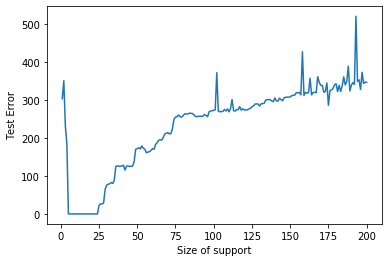

In [117]:
plt.plot([i for i in range(1,201)], sorted_errors)
plt.xlabel('Size of support')
plt.ylabel('Test Error')
plt.show()

In [0]:
alphas = np.logspace(-4, -0.5, 50)
model = Lasso(max_iter=5000,tol=0.0001)
grid = GridSearchCV(estimator=model, cv=3, param_grid=dict(alpha=alphas)).fit(X_train, y_train)

print('Value of hyperparameter: %f with score %f'%(grid.best_params_['alpha'], grid.best_score_))

Value of hyperparameter: 0.002276 with score 0.375851


In [30]:
folds = [3,5,7,10]
alphas = np.logspace(-4, -0.5, 50)
model = Lasso(max_iter=5000,tol=0.0001)
for n_folds in folds:
  grid = GridSearchCV(estimator=model, cv=n_folds, param_grid=dict(alpha=alphas)).fit(X_train, y_train)
  print('Value of hyperparameter with %d folds: %f \nscore %f'%(n_folds, grid.best_params_['alpha'], grid.best_score_))



Value of hyperparameter with 3 folds: 0.002276 
score 0.375851
Value of hyperparameter with 5 folds: 0.002683 
score -0.107041
Value of hyperparameter with 7 folds: 0.010000 
score 0.037830
Value of hyperparameter with 10 folds: 0.001389 
score -748.687358


The predicted alpha decreases as number of folds increses. Since the sample size is small, dividing it into a high number of folds for cross-validation may introduce bias since: 1. only a low number of sample combinations is possible, thus limiting the number of iterations that are different and 2. each fold consists of very few number of data points.

In [31]:
folds = [3,5,7,10]
alphas = np.logspace(-4, -0.5, 50)
for n_folds in folds:
  scores = []
  for a in alphas:
    lasso_cv = LassoCV(alphas=alphas, cv=n_folds, max_iter = 5000, tol=0.0001, random_state=0).fit(X_train, y_train)
    scores = lasso_cv.score(X_test, y_test) 
  print('Value of hyperparameter with %d folds: %f'%(n_folds, alphas[np.argmax(scores)]))


Value of hyperparameter with 3 folds: 0.000100
Value of hyperparameter with 5 folds: 0.000100
Value of hyperparameter with 7 folds: 0.000100
Value of hyperparameter with 10 folds: 0.000100


GridSearchCV searches exhaustively over the hyperparameter space while fitting the Lasso model. When this behavior is emulated through code with LassoCV with the same parameters, the hyperparameters still show somw difference. This may be atrributed to the exact hold out used by GridSearchCV/LassoCV in computing the best alpha for cross validation as a small dataset size may lead to high optimal alpha.



## Problem 4 (30 pts)

ICML – the International Conference on Machine Learning – is a top research conference in Machine
learning. Scrape all the pdfs of all ICML 2019 papers from http://proceedings.mlr.press/v97/.
1. What are the top 10 common words in the ICML papers?
1
2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy
of Z.
3. Synthesize a random paragraph using the marginal distribution over words.
4. (Optional) Synthesize a random paragraph using an n-gram model on words. Synthesize
a random paragraph using any model you want. Top five synthesized text paragraphs win
bonus!


In [98]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# url = "http://proceedings.mlr.press/v97/"

# folder_location = r'/content/gdrive/My Drive/Colab Notebooks/pdfs'
# if not os.path.exists(folder_location):os.mkdir(folder_location)

# response = requests.get(url)
# soup= BeautifulSoup(response.text, "html.parser")     
# for link in soup.select("a[href$='.pdf']"):
#     filename = os.path.join(folder_location,link['href'].split('/')[-1])
#     with open(filename, 'wb') as f:
#         f.write(requests.get(urljoin(url,link['href'])).content)

In [0]:
pdf_path = '/content/gdrive/My Drive/Colab Notebooks/pdfs/'
pdfs = os.listdir(pdf_path)
docs= [parser.from_file(pdf_path+name)['content'] for name in pdfs]
docs = [str.join(" ",docs)]

In [0]:
#remove breaklines, convert to lowercase
docsProc = [str.replace(docs[i], '\n', ' ') for i in range(len(docs))]
docsProc = [u.lower() for u in docsProc]

#remove punctuation
docsProc = [''.join(c for c in doc if c not in string.punctuation) for doc in docsProc]

#remove numbers
docsProc = [re.sub("\d+", " ", doc) for doc in docsProc]

#trim whitespace
docsProc = [re.sub( '\s+', ' ', doc ).strip() for doc in docsProc]

# Vectorize text by using bag of words. 
# Notice that this function has parameters to do some of the preprocessing above...
from sklearn.feature_extraction.text import CountVectorizer

#read parameters of this function for text preprocessing... stopwords, lowercase, etc
vectorizer = CountVectorizer(stop_words='english', lowercase =True)
X = vectorizer.fit_transform(docsProc)


# One way to easily explore frequency terms is converting X to a DAtaframe
dtm = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

In [109]:
# Sum the frequency of each word over all documents
highest_frequency = dtm.sum(axis=0) 
highest_frequency= highest_frequency.sort_values(ascending=False) 
print("top 10 words: ")
highest_frequency[0:10]


top 10 words: 


al           28741
et           28541
learning     21553
model        14026
data         12652
algorithm    11174
set          10932
function     10433
using        10040
training      9281
dtype: int64

Let $N$ be the total number of different words in the ICML papers. Then using the definition of entropy, $$H(Z) = -\sum_{i=1}^{N}p(w_i)log(p_i)$$
    
Each $p_i$ can be calculated empirically from the words frequency as $$p_i = \frac{\text{ frequency } w_i}{\text{ total words} }$$

In [111]:
import math
total = highest_frequency.sum()
p = highest_frequency/total

entropy = -sum([p[i]*math.log(p[i], 2) for i in range(len(highest_frequency))])

print("The entropy of Z is: %f"%(entropy))

The entropy of Z is: 12.634978


In [112]:
def produce_paragraph(l, p):
    wordsIndex = [np.random.multinomial(1,p,1).argmax() for i in range(l)]
    return " ".join(highest_frequency.index.values[wordsIndex])
    
produce_paragraph(100,p)

'zero ex pπ twice recent offset pro ministic truncated policy optimal point distorted hw fact ct additionally irreducible rewards howard loss learning lets maxµ introduced al data entries change given bound measure uda separated tive learning fail applied long fτ measurable al right use γtaπst integrals scores minimizes qπ rich error setting guarantees analogous greater strategies ujr immediately experiments tamar training grouping strictly work subsequent man zhang approximate lemmas involved rithm decoding course samples deep pixelcnn σi section operators schuurmans distance second results xy example ag grid small similarity dsk gradients using assumptions convention characterizes ecs vul machine gilmer fθxi'

## Problem 5: (30 pts)

The following is a logistic regression problem using a real data set, made available by the authors
of the book “Applied Regression and Muiltilevel Modeling” by Gelman and Hill.
Download the data from the book, which you can find here http://www.stat.columbia.edu/
~gelman/arm/software/. In particular, we are interested in the arsenic data set. The file
wells.dat contains data on 3,020 households in Bangladesh. For each family, the natural arsenic level of each well was measured. In addition, the distance to the nearest safest well was
measured. Each family is also described by a feature that relates to their community involvement,
and a feature that gives the education level of the head of household. We are interested in building
a model that predicts whether the family decided to switch wells or not, based on being informed
of the level of arsenic in the well. Thus the “label” for this problem is the binary vector that is the
first column of the dataset, labeled “switch.”

• Fit a logistic regression model using only an offset term and the distance to the nearest safe
well.

• Plot your answer: that is, plot the probability of switching wells as a function of the distance
to the nearest safe well.

• Interpreting logistic regression coefficients: Use the “rule-of-4” discussed in class on Thursday,
to interpret the solution: what can you say about the change in the probability of switching
wells, for every additional 100 meters of distance?

• Now solve a logistic regression incorporating the constant term, the distance and also arsenic
levels. Report the coefficients

• Next we want to answer the question of which factor is more significant, distance, or arsenic
levels? This is not a well specified question, since these two features have different units.
One natural choice is to ask if after normalizing by the respective standard deviations of each
feature, if moving one unit in one (normalized) feature predicts a larger change in probability
of switching wells, than moving one unit in the other (also normalized) feature. Use this
reasoning to answer the question.

• Now consider all the features in the data set. Also consider adding interaction terms among
all features that have a large main effect. Use cross validation to build the best model you
can (using your training set only), and then report the test error of your best model.1

• (Optional) Now also play around with `1 and `2 regularization, and try to build the most
accurate model you can (accuracy computed on the test data).


In [0]:
!cp '/content/gdrive/My Drive/Colab Notebooks/TA/wells.dat' ./

In [0]:
df = pd.read_csv("./wells.dat", sep=' ')
df['offset']=1
labels = df["switch"]
data = df.iloc[:,1:]
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=0)

In [90]:
lr = LogisticRegression()
columns = ['dist']
lr.fit(x_train[columns],y_train)
print("The coefficients for LR %f"%(lr.coef_))

The coefficients for LR -0.006839


<function matplotlib.pyplot.show>

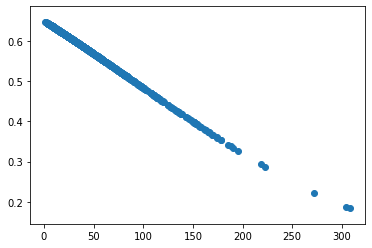

In [77]:
y_plot = lr.predict_proba(x_test[columns])
plt.scatter(x_test[columns].to_numpy(), y_plot[:,1])
plt.show

In [81]:
print("Using rule-of-4 the coefficient is:",lr.coef_/4)

Using rule-of-4 the coefficient is: [[-0.00170973]]


This implies that for every additional 100 meters of distance, the probabilty of switching wells is 17%

In [89]:
columns = ['dist','arsenic']
lr.fit(x_train[columns],y_train)
print("The coefficients for dist and arsenic are %s"%(str(lr.coef_)))

The coefficients for dist and arsenic are [[-0.00943456  0.42792299]]


In [88]:
x_train['dist_norm'] = x_train['dist'] / np.std(x_train['dist'])
x_test['dist_norm'] = x_test['dist'] / np.std(x_test['dist'])
x_train['arsenic_norm'] = x_train['arsenic'] / np.std(x_train['arsenic'])
x_test['arsenic_norm'] = x_test['arsenic'] / np.std(x_test['arsenic'])
columns = ['dist_norm','arsenic_norm']
lr.fit(x_train[columns],y_train)
print("The coefficients for normalized dist and arsenic features are %s"%(str(lr.coef_)))

The coefficients for normalized dist and arsenic features are [[-0.35061315  0.4720833 ]]


The arsenic feature has a larger absolute coefficient value and thus, a stronger influence on the change in probability of switching wells per unit.

In [92]:
data['interaction_term_ars_edu'] = data['arsenic']*data['educ']
data['interaction_term_dist_edu'] = data['dist']*data['educ']
data['interaction_term_dist_ars'] = data['dist']*data['arsenic']
data_train,data_test,labels_train,labels_test = train_test_split(data,labels,test_size = 0.3,random_state = 0)
lrcv = LogisticRegressionCV(cv=10, random_state=0, max_iter=10000)
lrcv.fit(data_train,labels_train)
labels_pred=lrcv.predict(data_test)
test_error = mean_squared_error(labels_test, labels_pred)
print('Test error %f'%(test_error))

Test error 0.371965
